In [1]:
using RCall, Gadfly, DataFrames
addprocs(6);
import Lazy.@>, Lazy.@>>


Attaching package: ‘dplyr’

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki
The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last

    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/seth/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/seth/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/seth/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataAr

In [2]:
using LogTopReg
include("../juliafromR.jl");
Y,X,pss0 = getfocaldata();

  Bumped column 18 to type character on data row 6, field contains 'Activity (rest)'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses the first 5 rows, the middle 5 rows and the last 5 rows, so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.
Warning in fread(files[i]) :
  Bumped column 19 to type character on data row 6, field contains 'In 2m? (8)'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they wil

In [3]:
blocks = @> vcat(map(x -> repeat(collect(x),inner=[20]),1:3)...,map(x -> repeat(collect(x),inner=[19]),4:5)...) sample(98,replace=false);

In [88]:
@time cv20 = @parallel (vcat) for i in 1:5
    topiclmm(Y[blocks.!=i],X[:,blocks.!=i],pss0,20,hyperparameter(τ_β=1.0),1000,2);
end;

905.036400 seconds (31.12 M allocations: 1.486 GB, 0.48% gc time)


In [89]:
@time lp20 = @parallel (vcat) for i in 1:5
    lppd(Y[blocks.==i],X[:,blocks.==i],cv20[i],3);
end;

264.554801 seconds (173.39 M allocations: 13.242 GB, 9.14% gc time)


In [55]:
lp5 = DataFrame(lp=vec(lp),
fold=repeat(vcat(map(x -> repeat(collect(x),inner=[20]),1:3)...,map(x -> repeat(collect(x),inner=[19]),4:5)...),outer=[500]),
sample=repeat(collect(1:98),outer=[500]),
iter=repeat(collect(1:500),inner=[98]));

In [3]:
fit = topiclmm(Y,X,pss0,5,hyperparameter(),500);

Dict{Symbol,Union{AbstractArray{T,N},Dict{Symbol,Float64}}} with 10 entries:
  :τ              => [0.0401169,0.0362136,0.0448322,0.0572609,0.0931765,0.10250…
  :μ              => 5x500 Array{Float64,2}:…
  :loglik         => 98x500 Array{Float64,2}:…
  :σ2             => 5x500 Array{Float64,2}:…
  :z              => […
  :lpθ            => [-762.92,-763.472,-738.074,-725.536,-692.754,-681.844,-662…
  :η              => 5x98x500 Array{Float64,3}:…
  :topic          => 5x500 Array{LogTopReg.VectorPosterior{T<:LogTopReg.PostPre…
  :β              => 9x5x500 Array{Float64,3}:…
  :hyperparameter => Dict(:τ_β=>1.0,:ν0_τ=>1.0,:ν0_σ2η=>1.0,:τ0_τ=>0.25,:σ0_σ2η…

In [31]:
#K = repeat([10],inner=[5]);
K = [0.01,0.5,1.0,5.0,25.0];
@time fit = @parallel (vcat) for k in K
    topiclmm(Y,X,pss0,15,hyperparameter(τ0_τ=k,ν0_τ=10.0),5000,10);
end;

3061.156063 seconds (23.53 M allocations: 1.184 GB, 0.06% gc time)


Socket from unknown remote worker in worker 2Socket from unknown remote worker in worker 8

In [5]:
ns = length(fit[:τ]);

In [50]:
lpdat = DataFrame(loglik=vcat(map(y -> y[:lpθ] + sum(y[:loglik],1)',fit)...)[:],chain=repeat(map(string,1:length(K)),inner=[ns]),
iter=repeat(collect(1:ns),outer=[length(K)]),K=map(string,repeat(K,inner=[ns])));

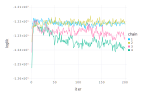

In [51]:
plot(lpdat,y="loglik",x="iter",color="chain",Geom.line)

In [34]:
lldat = DataFrame(loglik=vcat(map(y -> sum(y[:loglik],1)',fit)...)[:],chain=repeat(map(string,1:length(K)),inner=[ns]),
iter=repeat(collect(1:ns),outer=[length(K)]),K=map(string,repeat(K,inner=[ns])));

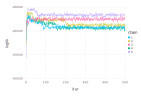

In [35]:
plot(lldat,y="loglik",x="iter",color="chain",Geom.line)

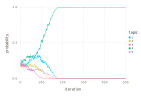

In [6]:
i = 1;
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:5),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[5]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

In [16]:
writefit(fit[2],"/home/seth/analysis/logtopreg/fit38_nosex/")

LoadError: LoadError: MethodError: `writefit` has no method matching writefit(::Dict{Symbol,Union{AbstractArray{T,N},Dict{Symbol,Float64}}}, ::ASCIIString)
Closest candidates are:
  writefit(!Matched::Dict{Symbol,AbstractArray{T,N}}, ::ASCIIString)
while loading In[16], in expression starting on line 1

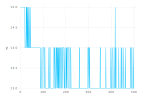

In [61]:
plot(y=mapslices(x -> length(unique(x)),vcat(fit[1][:z]...),1),Geom.line)

In [23]:
lp15 = lppd(Y,X,fit[3],10);

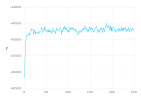

In [25]:
plot(y=sum(lp15,1)[:],Geom.line)

In [161]:
warmup=10;
loo = Vector{Dict{Symbol,Any}}(length(K))
rcopy("library(loo)");

In [205]:
globalEnv[:lp] = lp15[:,(warmup+1):ns]';
R"loo(lp)"

RCall.RObject{RCall.VecSxp}
Computed from 490 by 98 log-likelihood matrix

         Estimate     SE
elpd_loo -69629.3 1966.3
p_loo      1106.5   87.5
looic    139258.6 3932.7


In [118]:
globalEnv[:lp] = mapreduce(x -> sum(x,2),hcat,lp[3])[(warmup+1):ns,:];
R"loo1 <- loo(lp)"
globalEnv[:lp] = mapreduce(x -> sum(x,2),hcat,lp[2])[(warmup+1):ns,:];
R"loo2 <- loo(lp)"
R"compare(loo1,loo2)"

RCall.RObject{RCall.RealSxp}
elpd_diff        se 
     -4.1       4.8 
